## Datos ICFES


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels
import sklearn.linear_model as lm
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
#Combinar vab de calidad de vida. PCA categórico??

c:\Users\marti\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (76,78) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0    318354
1    102512
Name: COLE_NATURALEZA, dtype: int64

In [9]:
#Datos eliminados. Archivo muy pesado. Se trabaja con el archivo limpiado data.csv
data=pd.read_csv("C:/Users/marti/OneDrive/Documentos/personal/Universidad/Econometria/Saber_11.csv")
#Limpieza
column_descartadas=data.columns[[0,1,3,4,5,6,8,9,10,11,12,13,16,19,20,22,24,25,26,27,28,33,37,38,41,43,44,45,46,47,48,51,52,53,55,56,57,58,59,61,62,64,65,67,68,70,71,73,74,76,77,78,79,80,81]]#Lista de nombres de columnas a descartar"ESTU_TIPODOCUMENTO","ESTU_NACIONALIDAD","ESTU_NACIONALIDAD","ESTU_"
data.drop(column_descartadas, inplace=True,axis=1) 

#Eliminación filas sin info:
data=data[data.ESTU_GENERO != "-"]#eliminación filas sin género
data=data[(data.FAMI_ESTRATOVIVIENDA != "-" ) & (data.FAMI_ESTRATOVIVIENDA !="Sin Estrato")& ~( data.FAMI_ESTRATOVIVIENDA.isna())] #Eliminación filas sin especificación de estrato (& realiza elemento a elemento)
data=data[data.FAMI_PERSONASHOGAR != "-"]
data=data[(data.FAMI_EDUCACIONPADRE != "-")&(data.FAMI_EDUCACIONPADRE != "No Aplica")&(data.FAMI_EDUCACIONPADRE !="No sabe")]
data=data[(data.FAMI_EDUCACIONMADRE != "-")&(data.FAMI_EDUCACIONMADRE != "No Aplica")&(data.FAMI_EDUCACIONMADRE !="No sabe")]

data=data[(data.FAMI_TIENEINTERNET != "-")]
data=data[(data.FAMI_TIENECOMPUTADOR != "-")]


data=data[(data.FAMI_NUMLIBROS != "-")]
data=data[(data.ESTU_DEDICACIONLECTURADIARIA !="-")]
data=data[(data.ESTU_DEDICACIONINTERNET !="-")]

data=data[(data.FAMI_COMELECHEDERIVADOS != "-")]
data=data[(data.FAMI_COMECARNEPESCADOHUEVO != "-")]
data=data[(data.FAMI_COMECEREALFRUTOSLEGUMBRE != "-")]

data=data[(data.ESTU_HORASSEMANATRABAJA != "-")]


#Resumen info
# data.info()
#print(data.describe(include=["O"]))#Descripción categóricas
#data.head()
#Creación variables

#Variable género es útil en regresión individual
#data.ESTU_GENERO=pd.get_dummies(data.ESTU_GENERO).M #0 si es mujer, 1 si es hombre
#Oficiales/no oficiales
data.COLE_NATURALEZA=(data.COLE_NATURALEZA.eq("NO OFICIAL")).astype(int)
#Rural/urbano
data.COLE_AREA_UBICACION=(data.COLE_AREA_UBICACION.eq("URBANO")).astype(int)

data.ESTU_TIENEETNIA= (data.ESTU_TIENEETNIA=="Si").astype(int)
data.FAMI_ESTRATOVIVIENDA=data.FAMI_ESTRATOVIVIENDA.str.split(" ").str[1].astype(int) #Extraer solo el número del estrato

condiciones = [
    data['FAMI_PERSONASHOGAR'].eq('1 a 2'), data['FAMI_PERSONASHOGAR'].eq('3 a 4'),
    data['FAMI_PERSONASHOGAR'].eq('5 a 6'),data['FAMI_PERSONASHOGAR'].eq('7 a 8'),
    data['FAMI_PERSONASHOGAR'].eq('9 o más')
]
opciones = [1,3,5,7,9]
data.FAMI_PERSONASHOGAR = np.select(condiciones, opciones, default=0)
#data.FAMI_PERSONASHOGAR =(data.FAMI_PERSONASHOGAR >= 7).astype(int)

#Conectividad
condiciones = [
    data.FAMI_TIENECOMPUTADOR.eq("Si") |data.FAMI_TIENEINTERNET.eq('Si')
]
opciones=[1]
data.FAMI_TIENECOMPUTADOR=np.select(condiciones, opciones, default=0)

data.drop("FAMI_TIENEINTERNET", inplace=True,axis=1)
data.rename(columns = {'FAMI_TIENECOMPUTADOR':'conectividad'}, inplace = True) #se puede cambiar: asignar a data["conectividad"] directamente

#Libros
condiciones = [
    data['FAMI_NUMLIBROS'].eq('0 A 10 LIBROS'), data['FAMI_NUMLIBROS'].eq('11 A 25 LIBROS'),
    data['FAMI_NUMLIBROS'].eq('26 A 100 LIBROS'),data['FAMI_NUMLIBROS'].eq('MÁS DE 100 LIBROS')
]
opciones = [10,25,50,100]
data.FAMI_NUMLIBROS=np.select(condiciones, opciones, default=0)


#Dedicación
condiciones = [
    data['ESTU_DEDICACIONLECTURADIARIA'].eq('No leo por entretenimiento'),
    data['ESTU_DEDICACIONLECTURADIARIA'].eq('30 minutos o menos'),
    data['ESTU_DEDICACIONLECTURADIARIA'].eq('Entre 30 y 60 minutos'),
    data['ESTU_DEDICACIONLECTURADIARIA'].eq('Entre 1 y 2 horas'),
    data['ESTU_DEDICACIONLECTURADIARIA'].eq('Más de 2 horas')
]
opciones = [0,3,6,12,18]
data.ESTU_DEDICACIONLECTURADIARIA=np.select(condiciones, opciones, default=0)


condiciones = [
    data['ESTU_DEDICACIONINTERNET'].eq('No Navega Internet'),
    data['ESTU_DEDICACIONINTERNET'].eq('30 minutos o menos'),
    data['ESTU_DEDICACIONINTERNET'].eq('Entre 30 y 60 minutos'),
    data['ESTU_DEDICACIONINTERNET'].eq('Entre 1 y 3 horas'),
    data['ESTU_DEDICACIONINTERNET'].eq('Más de 3 horas')
]
opciones = [0,3,6,12,18]
data.ESTU_DEDICACIONINTERNET=np.select(condiciones, opciones, default=0)

#Alimentación
condiciones = [
    data['FAMI_COMELECHEDERIVADOS'].eq('3 a 5 veces por semana')| data['FAMI_COMELECHEDERIVADOS'].eq('Todos o casi todos los días')
]
opciones = [1]
data.FAMI_COMELECHEDERIVADOS=np.select(condiciones, opciones, default=0)

condiciones = [
    data['FAMI_COMECARNEPESCADOHUEVO'].eq('3 a 5 veces por semana')| data['FAMI_COMECARNEPESCADOHUEVO'].eq('Todos o casi todos los días')
]
opciones = [1]
data.FAMI_COMECARNEPESCADOHUEVO=np.select(condiciones, opciones, default=0)

condiciones = [
    data['FAMI_COMECEREALFRUTOSLEGUMBRE'].eq('3 a 5 veces por semana')| data['FAMI_COMECEREALFRUTOSLEGUMBRE'].eq('Todos o casi todos los días')
]
opciones = [1]
data.FAMI_COMECEREALFRUTOSLEGUMBRE=np.select(condiciones, opciones, default=0)

data["alimentacion"]=data[['FAMI_COMELECHEDERIVADOS', 'FAMI_COMECARNEPESCADOHUEVO','FAMI_COMECEREALFRUTOSLEGUMBRE']].sum(axis=1)
data.alimentacion=(data.alimentacion>=2).astype(int)

data.drop(['FAMI_COMELECHEDERIVADOS','FAMI_COMECARNEPESCADOHUEVO','FAMI_COMECEREALFRUTOSLEGUMBRE'], inplace=True,axis=1)
#Trabaja
data.ESTU_HORASSEMANATRABAJA=(~ data.ESTU_HORASSEMANATRABAJA.eq('0')).astype(int)

#data_colegios1
# condiciones = [
#     data.FAMI_EDUCACIONPADRE.eq("Secundaria (Bachillerato) completa") |data.FAMI_EDUCACIONPADRE.eq('Educación profesional completa')
#     |data.FAMI_EDUCACIONPADRE.eq("Técnica o tecnológica completa")|data.FAMI_EDUCACIONPADRE.eq("Técnica o tecnológica incompleta")
#     |data.FAMI_EDUCACIONPADRE.eq("Educación profesional incompleta")| data.FAMI_EDUCACIONPADRE.eq("Postgrado")
# ]
# opciones=[1]
# data.FAMI_EDUCACIONPADRE=np.select(condiciones, opciones, default=0)
# condiciones = [
#     data.FAMI_EDUCACIONMADRE.eq("Secundaria (Bachillerato) completa") | data.FAMI_EDUCACIONMADRE.eq('Educación profesional completa')
#     | data.FAMI_EDUCACIONMADRE.eq("Técnica o tecnológica completa")|data.FAMI_EDUCACIONMADRE.eq("Técnica o tecnológica incompleta")
#     |data.FAMI_EDUCACIONMADRE.eq("Educación profesional incompleta")| data.FAMI_EDUCACIONMADRE.eq("Postgrado")
# ]
# opciones=[1]
# data.FAMI_EDUCACIONMADRE=np.select(condiciones, opciones, default=0)

#Data_colegios2
# condiciones = [
#     data.FAMI_EDUCACIONPADRE.eq("Secundaria (Bachillerato) completa") |data.FAMI_EDUCACIONPADRE.eq('Educación profesional completa')
#     |data.FAMI_EDUCACIONPADRE.eq("Técnica o tecnológica completa")|data.FAMI_EDUCACIONPADRE.eq("Técnica o tecnológica incompleta")
#     |data.FAMI_EDUCACIONPADRE.eq("Educación profesional incompleta")| data.FAMI_EDUCACIONPADRE.eq("Postgrado")
#     |data.FAMI_EDUCACIONMADRE.eq("Secundaria (Bachillerato) completa") | data.FAMI_EDUCACIONMADRE.eq('Educación profesional completa')
#     |data.FAMI_EDUCACIONMADRE.eq("Técnica o tecnológica completa")|data.FAMI_EDUCACIONMADRE.eq("Técnica o tecnológica incompleta")
#     |data.FAMI_EDUCACIONMADRE.eq("Educación profesional incompleta")| data.FAMI_EDUCACIONMADRE.eq("Postgrado")
# ]

# opciones=[1]
# data["Educacion_padres"]=np.select(condiciones, opciones, default=0)
# data.drop(["FAMI_EDUCACIONPADRE","FAMI_EDUCACIONMADRE"], inplace=True,axis=1)

#data_colegios3
condiciones = [
    data.FAMI_EDUCACIONPADRE.eq("Ninguno") |data.FAMI_EDUCACIONMADRE.eq('Ninguno'),
    data.FAMI_EDUCACIONPADRE.eq("Primaria incompleta") |data.FAMI_EDUCACIONMADRE.eq('Primaria incompleta'),
    data.FAMI_EDUCACIONPADRE.eq("Primaria completa") |data.FAMI_EDUCACIONMADRE.eq('Primaria completa'),
    data.FAMI_EDUCACIONPADRE.eq("Secundaria (Bachillerato) incompleta") |data.FAMI_EDUCACIONMADRE.eq('Secundaria (Bachillerato) incompleta'),
    data.FAMI_EDUCACIONPADRE.eq("Secundaria (Bachillerato) completa") |data.FAMI_EDUCACIONMADRE.eq('Secundaria (Bachillerato) completa'),
    data.FAMI_EDUCACIONPADRE.eq("Técnica o tecnológica incompleta") |data.FAMI_EDUCACIONMADRE.eq('Técnica o tecnológica incompleta'),
    data.FAMI_EDUCACIONPADRE.eq("Técnica o tecnológica completa") |data.FAMI_EDUCACIONMADRE.eq('Técnica o tecnológica completa'),
    data.FAMI_EDUCACIONPADRE.eq("Educación profesional incompleta") |data.FAMI_EDUCACIONMADRE.eq('Educación profesional incompleta'),
    data.FAMI_EDUCACIONPADRE.eq("Educación profesional completa") |data.FAMI_EDUCACIONMADRE.eq('Educación profesional completa'),
    data.FAMI_EDUCACIONPADRE.eq("Postgrado") |data.FAMI_EDUCACIONMADRE.eq('Postgrado'),
]

opciones=[0,1,2,3,4,5,6,7,8,9]
data["Educacion_padres"]=np.select(condiciones, opciones, default=0)
data.drop(["FAMI_EDUCACIONPADRE","FAMI_EDUCACIONMADRE"], inplace=True,axis=1)



#Agrupación por colegio para creación de archivo (caso regresión 1)
#'ESTU_DEDICACIONLECTURADIARIA','ESTU_DEDICACIONINTERNET','FAMI_NUMLIBROS' tienen relevancia para análisis individual
#data_colegios1=data.groupby(['COLE_NOMBRE_ESTABLECIMIENTO','COLE_NATURALEZA','COLE_AREA_UBICACION','COLE_DEPTO_UBICACION'],as_index=False)[['ESTU_TIENEETNIA','FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','FAMI_EDUCACIONPADRE','FAMI_EDUCACIONMADRE','ESTU_DEDICACIONLECTURADIARIA','ESTU_DEDICACIONINTERNET','FAMI_NUMLIBROS','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA','PUNT_GLOBAL']].mean()

#data_colegios2 
data_colegios2=data.groupby(['COLE_NOMBRE_ESTABLECIMIENTO','COLE_NATURALEZA','COLE_AREA_UBICACION','COLE_DEPTO_UBICACION'],as_index=False)[['ESTU_TIENEETNIA','FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','Educacion_padres','ESTU_DEDICACIONLECTURADIARIA','ESTU_DEDICACIONINTERNET','FAMI_NUMLIBROS','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA','PUNT_GLOBAL']].mean()

#transformación variables porcentuales al intervalo [0,100]
data_colegios2['ESTU_TIENEETNIA']=100*data_colegios2['ESTU_TIENEETNIA']
#data_colegios2['Educacion_padres']=100*data_colegios2['Educacion_padres']#para regresión 2 punicamente
#data_colegios1['FAMI_EDUCACIONMADRE']=100*data_colegios1['FAMI_EDUCACIONMADRE'] #para regresión 1
data_colegios2['conectividad']=100*data_colegios2['conectividad']
data_colegios2['alimentacion']=100*data_colegios2['alimentacion']
data_colegios2['ESTU_HORASSEMANATRABAJA']=100*data_colegios2['ESTU_HORASSEMANATRABAJA']

#Creación archivo
# data_colegios2.to_csv(path_or_buf="C:/Users/marti/OneDrive/Documentos/personal/Universidad/Econometria/Proyecto/Proyecto-Econometria-I/data_colegios3.csv")


c:\Users\marti\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (76,78) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [34]:
#Lectura de archivo creado 
# datos=pd.read_csv("C:/Users/marti/OneDrive/Documentos/personal/Universidad/Econometria/Proyecto/Proyecto-Econometria-I/data_colegios1.csv")
# data_reg=datos[['COLE_NATURALEZA', 'COLE_AREA_UBICACION', 'ESTU_TIENEETNIA', 'FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','FAMI_EDUCACIONPADRE','FAMI_EDUCACIONMADRE','ESTU_DEDICACIONLECTURADIARIA','ESTU_DEDICACIONINTERNET','FAMI_NUMLIBROS','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA','PUNT_GLOBAL']]

# datos=pd.read_csv("C:/Users/marti/OneDrive/Documentos/personal/Universidad/Econometria/Proyecto/Proyecto-Econometria-I/data_colegios2.csv")
# data_reg3=datos[['COLE_NATURALEZA', 'COLE_AREA_UBICACION', 'ESTU_TIENEETNIA', 'FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','Educacion_padres','ESTU_DEDICACIONLECTURADIARIA','ESTU_DEDICACIONINTERNET','FAMI_NUMLIBROS','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA','PUNT_GLOBAL']]

datos=pd.read_csv("C:/Users/marti/OneDrive/Documentos/personal/Universidad/Econometria/Proyecto/Proyecto-Econometria-I/data_colegios3.csv")
data_reg3=datos[['COLE_NATURALEZA', 'COLE_AREA_UBICACION', 'ESTU_TIENEETNIA', 'FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','Educacion_padres','ESTU_DEDICACIONLECTURADIARIA','ESTU_DEDICACIONINTERNET','FAMI_NUMLIBROS','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA','PUNT_GLOBAL']]


<AxesSubplot:xlabel='COLE_AREA_UBICACION', ylabel='PUNT_GLOBAL'>

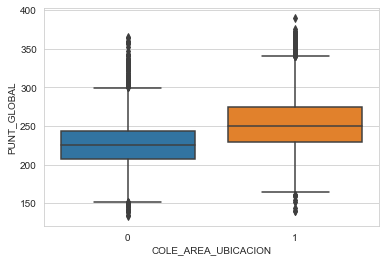

In [26]:
#Visualizaciones
sns.boxplot(x="COLE_AREA_UBICACION",y="PUNT_GLOBAL",data=data_reg3)
#sns.boxplot(x="FAMI_ESTRATOVIVIENDA",y="PUNT_GLOBAL",data=data_reg3)#.iloc[:,1:])

#sns.heatmap(data_reg3.corr(),cmap="Blues")
#data_reg3.corr()
#data_reg3.info()

#sns.FacetGrid(data_reg,hue="COLE_AREA_UBICACION",height=3)\
#   .map(sns.distplot,"PUNT_GLOBAL")\
#    .add_legend() 
#plt.show()


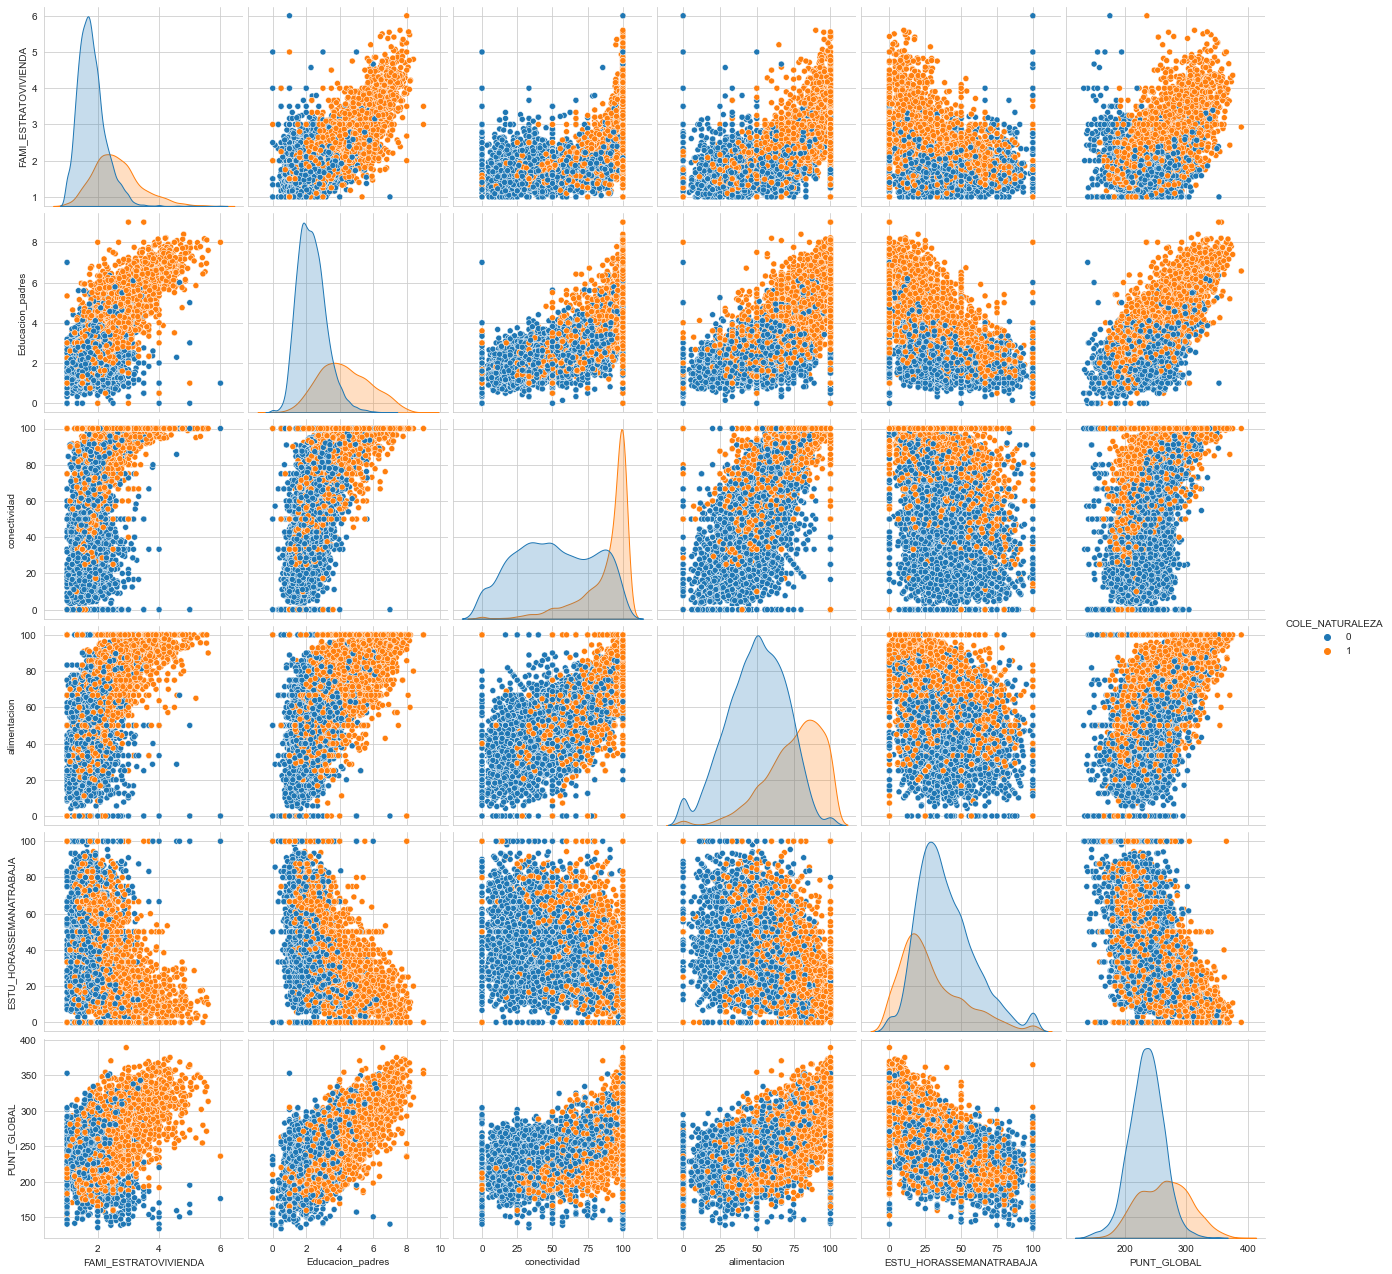

In [16]:
# cuanti=data_reg[['COLE_NATURALEZA','FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','FAMI_EDUCACIONPADRE','FAMI_EDUCACIONMADRE','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA','PUNT_GLOBAL']]
# plt.close()
# sns.set_style("whitegrid")
# sns.pairplot(cuanti,hue="COLE_NATURALEZA",height=3)
# plt.show()

cuanti=data_reg3[['COLE_NATURALEZA','FAMI_ESTRATOVIVIENDA','Educacion_padres','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA','PUNT_GLOBAL']]
plt.close()
sns.set_style("whitegrid")
sns.pairplot(cuanti,hue="COLE_NATURALEZA",height=3)
plt.show()

In [35]:
X = sm.add_constant(data_reg3.loc[:, data_reg3.columns != 'PUNT_GLOBAL'])
reg = sm.OLS(data_reg3["PUNT_GLOBAL"],X)
model_fit=reg.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:            PUNT_GLOBAL   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     1561.
Date:                Sat, 21 May 2022   Prob (F-statistic):               0.00
Time:                        21:50:31   Log-Likelihood:                -44662.
No. Observations:               10016   AIC:                         8.935e+04
Df Residuals:                   10003   BIC:                         8.944e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

c:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [36]:
# names = ['Lagrange multiplier statistic', 'p-value',
#         'f-value', 'f p-value']
# test = sms.het_breuschpagan(results2.resid, results2.model.exog)

# lzip(names,test)

plt.style.use('seaborn') # pretty matplotlib plots

# fitted values (need a constant term for intercept)
model_fitted_y = model_fit.fittedvalues

model_exog=model_fit.model.exog
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)

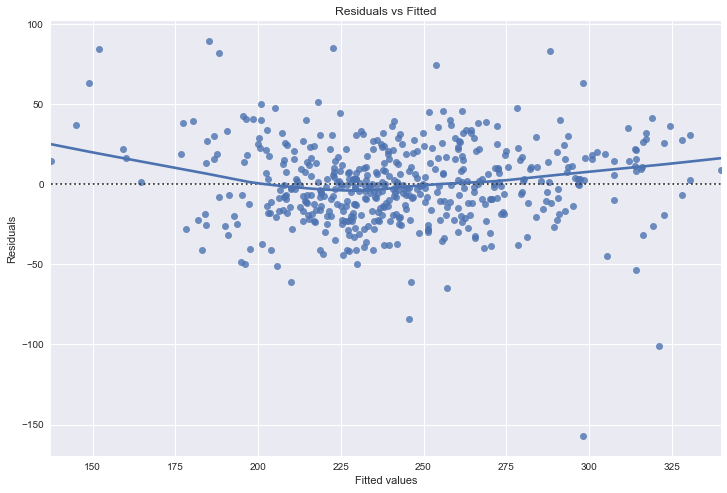

In [38]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

plot_lm_1.axes[0] = sns.residplot(x = model_fitted_y[:500],
                    y = model_residuals[:500],
                    data = data_reg3,
                    lowess = True)
  
# show the plot


plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')
plt.show()

In [42]:
#Regresión de educación padres en función de las demás vab
X = sm.add_constant(data_reg3[['COLE_NATURALEZA', 'COLE_AREA_UBICACION', 'ESTU_TIENEETNIA', 'FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA']])
reg = sm.OLS(data_reg3['Educacion_padres'],X)
resultados=reg.fit()
print(resultados.summary())

                            OLS Regression Results                            
Dep. Variable:       Educacion_padres   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     3773.
Date:                Sat, 21 May 2022   Prob (F-statistic):               0.00
Time:                        22:08:51   Log-Likelihood:                -11057.
No. Observations:               10016   AIC:                         2.213e+04
Df Residuals:                   10007   BIC:                         2.220e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

c:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [40]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                         feature         VIF
0                          const  110.187198
1                COLE_NATURALEZA    1.913601
2            COLE_AREA_UBICACION    1.760029
3                ESTU_TIENEETNIA    1.202433
4           FAMI_ESTRATOVIVIENDA    2.848608
5             FAMI_PERSONASHOGAR    1.369526
6               Educacion_padres    4.752247
7   ESTU_DEDICACIONLECTURADIARIA    1.166482
8        ESTU_DEDICACIONINTERNET    3.400709
9                 FAMI_NUMLIBROS    2.643845
10                  conectividad    4.203925
11                  alimentacion    2.854943
12       ESTU_HORASSEMANATRABAJA    1.615604


In [ ]:
#Ejemplo reducido 

X = sm.add_constant(data_reg3[['FAMI_ESTRATOVIVIENDA','Educacion_padres','alimentacion','ESTU_HORASSEMANATRABAJA']])
reg = sm.OLS(data_reg3["PUNT_GLOBAL"],X)
resultados=reg.fit()
print(resultados.summary())

fig = sm.graphics.plot_partregress_grid(resultados)
fig.tight_layout(pad=1.0)

In [39]:
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(model_residuals, model_exog)

lzip(names,test)

[('Lagrange multiplier statistic', 498.37955918933324),
 ('p-value', 4.9033205714903144e-99),
 ('f-value', 43.649659786060546),
 ('f p-value', 1.1152367371354694e-101)]

In [ ]:
regGLS = sm.GLS(data_reg["PUNT_GLOBAL"],X)
model2_fit=regGLS.fit()
print(model2_fit.summary())

In [ ]:

model2_exog=model2_fit.model.exog
# model residuals
model2_residuals = model2_fit.resid

names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(model2_residuals, model2_exog)

lzip(names,test)